<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/Acronimo_y_nombre_uc3m.png" width=50%/>

<h1><font color='#12007a'>Procesamiento de Lenguaje Natural con Aprendizaje Profundo</font></h1>
<p>Autora: Isabel Segura Bedmar</p>

<img align='right' src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" width=15%/>
</center>      

# 2.2: BiLSTM aplicado a la multi-clasificación de mensajes sexistas.

En un ejercicio anterior, aplicamos el modelo CNN a la multi-clasificación binaria de mensajes sexistas. En este nuevo ejercicio, el objetivo  es entrenar y evaluar un modelo BiLSTM para resolver la misma tarea.

El dataset a utilizar es la colección de textos proporcionada por los organizadores de la tareas EXIST 2021. Este dataset puede solicitarse para usos en investigación en el siguiente [link](#http://nlp.uned.es/exist2021/).


La tarea EXIST proponía dos tareas: i) clasificación binaria para distinguir entre mensajes sexistas y o no sexistas, y ii) multi-clasificación para clasificar los mensajes sexistas en alguna de las siguientes clases:

- IDEOLOGICAL AND INEQUALITY: "I think the whole equality thing is getting out of hand. We are different, thats how were made!"
- STEREOTYPING AND DOMINANCE: "Most women no longer have the desire or the knowledge to develop a high quality character, even if they wanted to.”
- OBJECTIFICATION: "Pareces una puta con ese pantalón"
- SEXUAL VIOLENCE: "Estas 4 no han conseguido su objetivo.El juez estima que se abrieron de patas"
- MISOGYNY AND NON-SEXUAL VIOLENCE: "Las mujeres de hoy en dia te enseñar a querer… estar soltero".

Para ver una descripción más detallada de estas clases, visita este este [link](#http://nlp.uned.es/exist2021/).



**NOTA PARA PODER EJECUTAR ESTE NOTEBOOK**:

1) Para poder ejercutar correctamente este notebook, deberás abrirlo en tu Google Drive (por ejemplo, en la carpeta 'Colab Notebooks').

2) Además, debes guardar el dataset en tu Google Drive, dentro de carpeta 'Colab Notebooks/data/exist2021/'.



## Cargar el dataset

Lo primero que debes hacer es cargar el dataset. Como hemos comentado antes, recuerda que para que puedas ejecutar este notebook, deberás haber descargado los ficheros del dataset y haberlos almacenados en tu carpeta 'Colab Notebooks/data/exist2021/' dentro de tu Gooogle Drive.



In [1]:
from google.colab import drive
# monta tu unidad de google drive
drive.mount('/content/drive')

# cambiamos el directorio de trabajo a la carpeta donde está almacenado el dataset
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/data/exist2021/')

Mounted at /content/drive


Cargamos los conjuntos de datos de training y evaluación en dos objetos dataframes de pandas:

In [2]:
import pandas as pd

df_train = pd.read_csv("train.tsv",  sep='\t')
df_test = pd.read_csv("test.tsv",  sep='\t')

print('tamaño training:', df_train.shape)
print('tamaño test:', df_test.shape)

# mostramos los primeros registros del training:
df_train.head()

tamaño training: (6977, 7)
tamaño test: (4368, 7)


,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality
1,EXIST2021,2,twitter,en,"Now, back to these women, the brave and the be...",non-sexist,non-sexist
2,EXIST2021,3,twitter,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification
3,EXIST2021,4,twitter,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist,non-sexist
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist


El dataset es multilingüe, vamos a quedarnos únicamente con los textos en inglés:

In [3]:
df_train=df_train[df_train['language']=='en']
df_test=df_test[df_test['language']=='en']
print('tamaño training:', df_train.shape)
print('tamaño test:', df_test.shape)


tamaño training: (3436, 7)
tamaño test: (2208, 7)


En esta tarea, nuestro objetivo es clasificar los mensajes sexistas en las cinco categorías anteriormente definidas. Los mensajes no sexistas no van a ser clasificados y por ese motivo, vamos a eliminarlos, o visto de otra forma, únicamente conservaremos los mensajes clasificados como sexistas en la tarea 1 (task1):

In [4]:
df_train = df_train[df_train['task1'] == 'sexist']
df_test = df_test[df_test['task1'] == 'sexist']

print('tamaño training:', df_train.shape)
print('tamaño test:', df_test.shape)

df_train.head()

tamaño training: (1636, 7)
tamaño test: (1158, 7)


,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality
2,EXIST2021,3,twitter,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification
5,EXIST2021,6,twitter,en,@Smithcouple971 Hello....m raj....m with good ...,sexist,sexual-violence
10,EXIST2021,11,twitter,en,@hapyshoper79 @Dis_Critic @MairiJCam @cazadams...,sexist,ideological-inequality
15,EXIST2021,16,twitter,en,@Ponderer_O_Purg @BynameRose @GameOverRos @nat...,sexist,ideological-inequality


En este ejercicio, sólo vamos a usar **text** y **task2**:


In [5]:
df_train = df_train.drop(['test_case', 'id', 'source', 'task1'], axis=1)
df_test = df_test.drop(['test_case', 'id', 'source', 'task1'], axis=1)
# renombramos task1 a label
df_train = df_train.rename(columns={'task2':'label'})
df_test = df_test.rename(columns={'task2':'label'})
# mostramos los primeros registros del training
df_train.head()

,language,text,label
0,en,"She calls herself ""anti-feminazi"" how about sh...",ideological-inequality
2,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",objectification
5,en,@Smithcouple971 Hello....m raj....m with good ...,sexual-violence
10,en,@hapyshoper79 @Dis_Critic @MairiJCam @cazadams...,ideological-inequality
15,en,@Ponderer_O_Purg @BynameRose @GameOverRos @nat...,ideological-inequality


### Distribución de las clases

En cualquier problema de clasificación, es importante conocer la distribución de las clases en el dataset.

In [6]:
counts_train = df_train['label'].value_counts().to_dict()
print("Distribución en training:", counts_train)
counts_test = df_test['label'].value_counts().to_dict()
print("Distribución en test:", counts_test)


Distribución en training: {'ideological-inequality': 386, 'stereotyping-dominance': 366, 'sexual-violence': 344, 'misogyny-non-sexual-violence': 284, 'objectification': 256}
Distribución en test: {'ideological-inequality': 333, 'stereotyping-dominance': 262, 'misogyny-non-sexual-violence': 215, 'sexual-violence': 198, 'objectification': 150}


<ipython-input-7-47cc4b87081f>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_train.set_xticklabels(list(counts_train.keys()), rotation=45)
<ipython-input-7-47cc4b87081f>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_test.set_xticklabels(list(counts_test.keys()), rotation=45)


Text(0, 0.5, 'Número de Instancias')

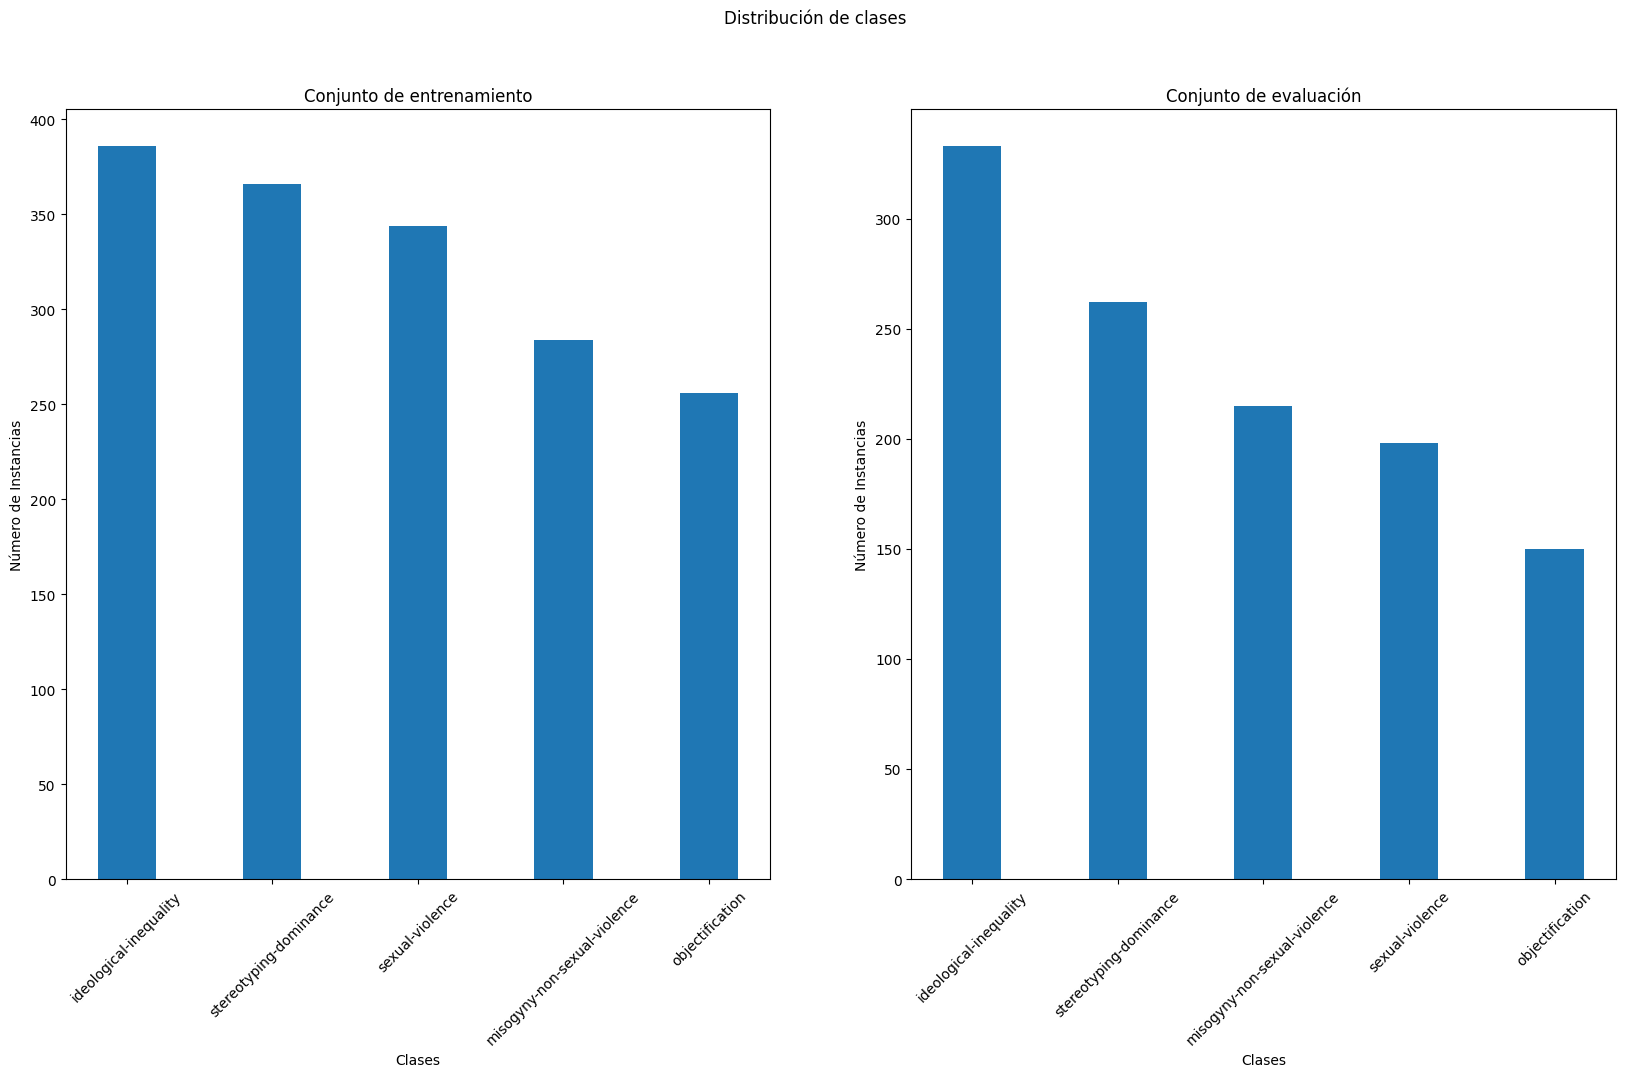

In [7]:
import matplotlib.pyplot as plt

fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Distribución de clases')
ax_train.bar(list(counts_train.keys()), counts_train.values(), width=0.4)
ax_train.set_xticklabels(list(counts_train.keys()), rotation=45)

ax_train.set_title('Conjunto de entrenamiento')
ax_train.set_xlabel('Clases')
ax_train.set_ylabel('Número de Instancias')

ax_test.bar(list(counts_test.keys()), counts_test.values(), width=0.4)
ax_test.set_xticklabels(list(counts_test.keys()), rotation=45)

ax_test.set_title('Conjunto de evaluación')
ax_test.set_xlabel('Clases')
ax_test.set_ylabel('Número de Instancias')

La distribución de las clases es similar en los dos conjuntos: training y test.
Respecto a las clases, la más frecuente es 'ideological inequality', y la menos 'objetification'. Es de esperar que el modelo proporcione resultados más bajos para las clases menos frecuentes.

## Label encoding

Esta tarea consiste en transformar las labels de formato a texto a un formato numérico.

En el caso de multi-clasifición, cada clase se va a representar con un vector one-hot.


In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

y_train = df_train['label'].tolist()
y_test = df_test['label'].tolist()

le = LabelEncoder()

print("antes de transform: ", y_train[:10])
y_train = le.fit_transform(y_train)
print("después de transform:", y_train[:10])
y_train_cat = to_categorical(y_train)
print("después de transform:", y_train_cat[:10])

y_test = le.fit_transform(y_test)
y_test_cat = to_categorical(y_test)

# guardamos el conjunto de labels y el número
LABELS = le.classes_
NUM_LABELS = len(LABELS)
idx2label={}
label2idx={}
for index, label in enumerate(LABELS):
    label2idx.update([(label, index)])
    idx2label.update([(index, label)])

# print(idx2label)
print('Labels:', label2idx)
print()


antes de transform:  ['ideological-inequality', 'objectification', 'sexual-violence', 'ideological-inequality', 'ideological-inequality', 'stereotyping-dominance', 'ideological-inequality', 'sexual-violence', 'ideological-inequality', 'sexual-violence']
después de transform: [0 2 3 0 0 4 0 3 0 3]
después de transform: [[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
Labels: {'ideological-inequality': 0, 'misogyny-non-sexual-violence': 1, 'objectification': 2, 'sexual-violence': 3, 'stereotyping-dominance': 4}



## Representación de los textos

Para que los textos puedan ser interpretados por el modelo CNN, necesitan también ser representado en un formato que pueda entender dicho modelo.
Vamos a aplicar los mismo pasos que se utilizaron en el ejercicio 2.1.


In [9]:
from keras.preprocessing.text import Tokenizer

X_train = df_train['text'].tolist()

tokenizer = Tokenizer(oov_token = True)
tokenizer.fit_on_texts(X_train)

tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario ={}".format(NUM_WORDS))

Tamaño del vocabulario =9427


In [10]:
from keras.utils import pad_sequences
MAX_LEN=45
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_train_pad = pad_sequences(encoded_train, maxlen = MAX_LEN,
                              padding='post', truncating='post')


## BiLSTM

Una vez que ya hemos procesado el texto, podemos definir el modelo.



In [11]:
import tensorflow as tf
# asegurar que los experimentos se pueden reproducir
tf.random.set_seed(42)
tf.__version__

'2.13.0'

### Crear el modelo

El modelo es muy similar al creado en el ejercicio 2.1, donde el objetivo era aplciar un modelo CNN para la tarea de clasificación binaria.
La única diferencia es la última capa. En este ejercicio, en lugar de usar una capa con una función sigmoid, vamos a utilizar una capa con una función **softmax**:

In [12]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

model = Sequential()
EMBEDDING_SIZE=50 #probar con 200, 300
model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN))

from keras.layers import Bidirectional, LSTM, Dropout, Dense

DROPOUT = 0.4

model.add(Bidirectional(LSTM(60, return_sequences=True, recurrent_dropout=0.2)))
# Añadimos una capaz droput después de la capa bilstm
model.add(Dropout(DROPOUT))

model.add(Bidirectional(LSTM(32, recurrent_dropout=0.2)))
model.add(Dropout(DROPOUT))

model.add(Dense(60, activation='relu'))

A continuación, ya podemos añadir otras capas como una capa Densa (suelen mejorar los resultados de clasificación).
La última capa usa la función **softmax** con cinco neuronas, una por cada clase, y va a devolver una probabilidad por cada una de ellas.
El modelo va a proponer la clase con mayor probabilidad.

Además, debemos indicar el optimizador y la función de coste, que al ser un problema de multi-clasificación debe ser **categorical_crossentropy**:

In [13]:
model.add(Dense(NUM_LABELS, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 50)            471350    
                                                                 
 bidirectional (Bidirection  (None, 45, 120)           53280     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 45, 120)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                39168     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 60)                3

### Entrenar el modelo



In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Para el entrenamiento después de 3 epochs sin el error en el conjunto de validación no mejora
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


In [15]:
epochs = 10
batch_size = 16

# training
history=model.fit(encoded_train_pad,  # textos preprocesados
                  y_train_cat,          # labels en formato one-hot
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )


Epoch 1/10
82/82 [==============================] - 88s 876ms/step - loss: 1.5743 - accuracy: 0.2668 - val_loss: 1.5622 - val_accuracy: 0.2896
Epoch 2/10
82/82 [==============================] - 67s 823ms/step - loss: 1.3596 - accuracy: 0.3960 - val_loss: 1.4279 - val_accuracy: 0.3628
Epoch 3/10
82/82 [==============================] - 62s 758ms/step - loss: 1.0464 - accuracy: 0.5268 - val_loss: 1.4622 - val_accuracy: 0.3902
Epoch 4/10
82/82 [==============================] - 59s 719ms/step - loss: 0.7355 - accuracy: 0.6873 - val_loss: 1.6456 - val_accuracy: 0.4634
Epoch 5/10
82/82 [==============================] - 59s 717ms/step - loss: 0.5003 - accuracy: 0.7592 - val_loss: 1.8557 - val_accuracy: 0.4543


El entrenamiento se detiene en la epoch 5.

### Curvas de aprendizaje

Estos gráficos nos permiten ver cómo el modelo aprende a lo largo de su entrenamiento, en concreto, muestran sus resultados al ser evaluados en cada epoch sobre su conjunto de entrenamiento y el conjunto de validación. Se pueden mostrar gráficos distintos para el acuracy y para el error (su comportamiento será opuesto).

Estas curvas se utilizan para diagnosticar un modelo que no es capaz de resolver la tarea, que sufre de sobre-aprendizaje (se ajusta perfecgtamente al conjunto de entrenamiento, pero no es capaz de resolver el problema en el conjunto de validación), o si el modelo está bien ajustado.




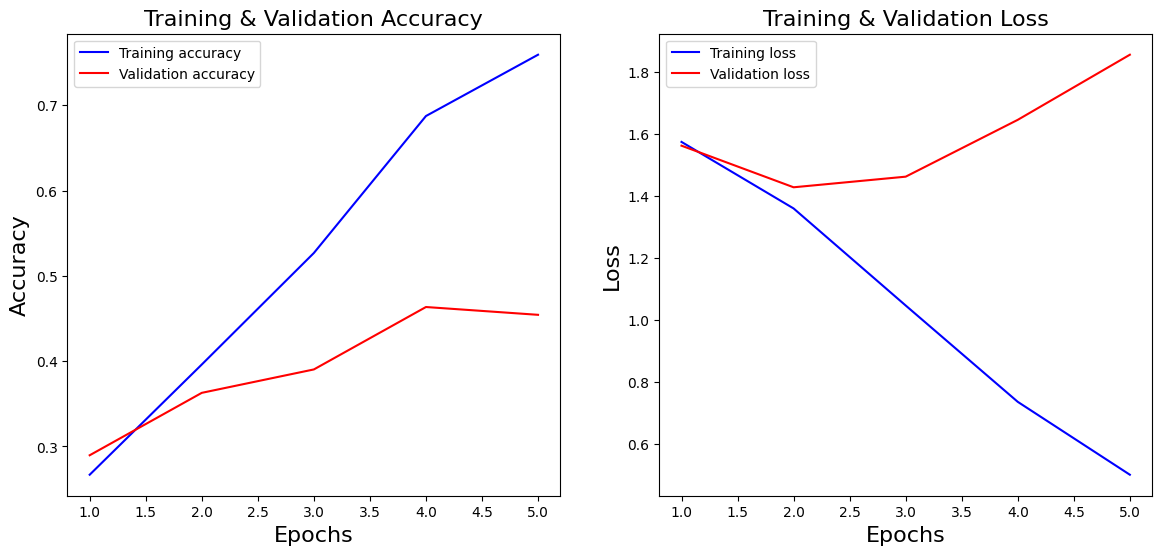

In [16]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Curva accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Curva loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Si nos fijamos en las curva del error, mientras que la curva del entrenamiento se aproxima a 0, el error en la validación aumenta. Esto significa que el modelo no ha aprendido a resolver el problema.
Por tanto, será necesario utilizar más datos y además, investigar en un modelo más complejo que sea capaz de resolver la tarea.

Idealmente, ambas curvas loss deberían tender a 0. Ese caso significa que el modelo es capaz de generalizar y resolve la tarea en el conjunto de validación.

### Evaluar el modelo



Aunque las curvas de aprendizaje nos dicen que deberíamos seguir investigando en mejorar el modelo, vamos a evaluarlo sobre el conjunto test. En primer lugar, vamos a obtener las métricas loss y  accuracy en dicho conjunto (que no ha sido utilizado en ninguna fase del entrenamiento).

In [17]:
X_test = df_test['text'].tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

loss, accuracy = model.evaluate(encoded_test, y_test_cat, batch_size=batch_size)


73/73 [==============================] - 4s 51ms/step - loss: 2.1630 - accuracy: 0.3912


Es un acuracy bastante bajo (39.1%), ligeramente superior al obtenido por CNN (37%).

Es posible obtener una evaluación más detallada con las métricas de precisión, recall y F1, gracias a la librería sklearn:

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
y_pred = np.argmax(model.predict(encoded_test), axis=1)
print(y_pred[0:10])

print('accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=LABELS))

37/37 [==============================] - 4s 72ms/step
[0 4 4 4 2 1 0 1 0 0]
accuracy: 0.3911917098445596
                              precision    recall  f1-score   support

      ideological-inequality       0.75      0.40      0.52       333
misogyny-non-sexual-violence       0.22      0.25      0.23       215
             objectification       0.27      0.34      0.30       150
             sexual-violence       0.61      0.32      0.42       198
      stereotyping-dominance       0.35      0.58      0.43       262

                    accuracy                           0.39      1158
                   macro avg       0.44      0.38      0.38      1158
                weighted avg       0.47      0.39      0.40      1158



La macro F1 no supera el 39%, aunque es superior a la obtenida por CNN (37%).
La clase con mejor F1 es ideological-inequality (52%), que además es la clase con mayor número de instancias en el training.


[[133  44  13   6 137]
 [ 14  54  70  16  61]
 [  3  41  51  17  38]
 [  5  48  31  63  51]
 [ 23  60  25   2 152]]


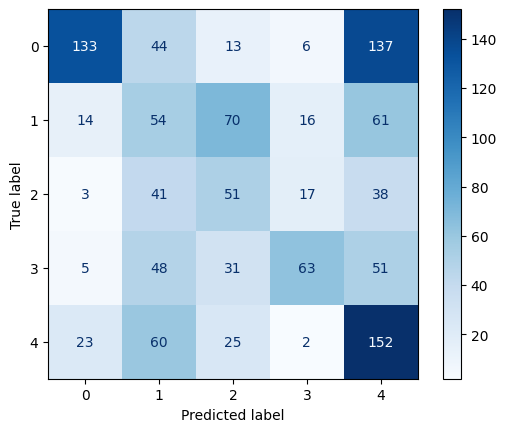

In [19]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)


Prueba con otras configuraciones de capas bilstm, prueba con capas GRU.

Además, también es recomendable que pruebes con un número distinto de epochs y batch y que modifiques el proceso de EarlyStopping.